In [2]:
#import torch
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
from numpy import square, sqrt, log, exp, zeros, std, mean
from torch import square_, sqrt_, log_, exp_, tensor#, div_, add_, mul_б 

width_sigma = 2 * sqrt(log(2))  # * np.sqrt(2)
width_lambda = 2.


def gauss(x, amp, mu, w):
    """
    :param x: iterable of numeric - wavelengths axis
    :param amp: float - Gaussian bell amplitude
    :param mu: float - peak position
    :param w: float - band width
    :return: numpy.array of floats

    Gauss curve
    """
    sigma = w / width_sigma
    return amp * exp(-square((x - mu) / sigma))

def lorentz(x, amp, x0, w):
    """
    :param x: iterable of numeric - wavelengths axis
    :param amp: float - pseudo-Voigt bell amplitude
    :param x0: float - peak position
    :param w: float - band width
    :return: numpy.array of floats

    Lorentz curve
    """
    return amp / (square(2 * (x - x0) / w) + 1.)

def gauss_(x, amp, w, mu, sum=True):
    n = amp.size(0)
    sigma = w / width_sigma
    t = x.repeat(n, 1).sub_(mu[:, None])
    t.div_(sigma[:, None])
    t = exp_(square_(t).neg_())
    t.mul_(amp[:, None])
    if sum:
        t = t.sum(0)
    return t

def lorentz_(x, amp, w, x0, sum=True):
    n = amp.size(0)
    t = x.repeat(n, 1)
    t.sub_(x0[:, None])
    t.mul_(width_lambda)
    t.div_(w[:, None])
    t = square_(t)
    t.add_(1)
    t = amp[:, None].div(t)
    if sum:
        t = t.sum(0)
    return t

def voigt_(x, amp, w, x0, gau, sum=True):
    x_ = tensor(x)     ########## changes
    x0_= tensor(x0)    ##########
    w_ = tensor(w)     ##########
    amp_ = tensor(amp) ##########
    gau_ = tensor(gau) ##########
    
    res = lorentz_(x_, amp_, w_, x0_, False).mul_(1 - gau_[:, None]).add_(gauss_(x_, amp_, w_, x0_, False).mul_(gau_[:, None]))
    if sum:
        res = res.sum(0)
    return res

def voigt(x, amp, x0, w, gauss_prop):
    """
    :param x: iterable of numeric - wavelengths axis
    :param amp: float - pseudo-Voigt bell amplitude
    :param x0: float - peak position
    :param w: float - band width
    :param gauss_prop:
    :return: numpy.array of floats

    Pseudo-Voigt curve
    """
    return gauss_prop * gauss(x, amp, x0, w) + (1 - gauss_prop) * lorentz(x, amp, x0, w)

# Аппроксимация полинома

In [4]:
# Исходная функция (пусть это будет полином третьей степени)
def original_function(x, coeffs):
    return sum([coeffs[i] * x ** i for i in range(len(coeffs))])

# Вычисление значения приспособленности хромосомы (MSE)
def fitness(chromosome, target_x, target_y):
    return -np.mean((np.array([original_function(x, chromosome) for x in target_x]) - np.array(target_y)) ** 2)

# Генерация начальной популяции
def generate_population(pop_size, num_coeffs):
    population = []
    for _ in range(pop_size):
        # Случайные коэффициенты в диапазоне [-20, 20]
        chromosome = [random.uniform(-20, 20) for _ in range(num_coeffs)]
        population.append(chromosome)
    return population

# Выбор родителей для скрещивания
#def select_parents(population):
#    # Выбор двух родителей случайным образом
#    return random.choices(population, k=2)

# Выбор родителей для скрещивания (метод турнира)
def select_parents(population, tournament_size):
    tournament = random.sample(population, tournament_size)
    return max(tournament, key=lambda x: fitness(x, TARGET_X, TARGET_Y))

# Скрещивание двух родителей
def crossover(parent1, parent2):
    #print('parent1 ', parent1)
    #print('parent2 ', parent2)
    crossover_point = random.randint(1, len(parent1) - 1)
    #print('cross point ', crossover_point)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

# Мутация
def mutate(chromosome, mutation_rate):
    for i in range(len(chromosome)):
        if random.random() < mutation_rate:
            chromosome[i] += random.uniform(-2, 2)  # Увеличим диапазон мутации
    return chromosome

# Генетический алгоритм
def genetic_algorithm(pop_size, generations, mutation_rate, target_x, target_y, tournament_size):
    num_coeffs = 4  # Количество коэффициентов для полинома третьей степени
    population = generate_population(pop_size, num_coeffs)
    print(population)
    for generation in range(generations):
        print("Generation:", generation + 1)
        new_population = []
        for _ in range(pop_size // 2):  # Создаем новое поколение, заполняя популяцию вдвое меньшего размера
            parent1 = select_parents(population, tournament_size)
            parent2 = select_parents(population, tournament_size)
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            new_population.extend([child1, child2])
        population = new_population
        population.sort(key=lambda x: fitness(x, target_x, target_y), reverse=True)  # Сортировка по убыванию приспособленности
        best_individual = population[0]
        best_fitness = fitness(best_individual, target_x, target_y)
        print("Best Fitness:", best_fitness)
        print("Best Individual (Coefficients):", best_individual)
        print()
    print("Original Coefficients:", np.polyfit(target_x, target_y, 3))
    return best_individual

# Пример использования генетического алгоритма

POPULATION_SIZE = 100
GENERATIONS = 100
MUTATION_RATE = 0.1
TARGET_X = np.linspace(-10, 10, 100)  # Значения x, для которых мы хотим приблизить полином
#TARGET_Y = [-40.1 * x ** 3 + 10 * x ** 2 + 4 * x - 50 for x in TARGET_X]  # Значения y, соответствующие TARGET_X
TARGET_COEFFS = [0., 0., -20., 100.] # c + __*x + __*x^2 + __*x^3
TARGET_Y = np.array([original_function(x, TARGET_COEFFS) for x in TARGET_X])
TOURNAMENT_SIZE = 5  # Размер турнира

best_individual = genetic_algorithm(POPULATION_SIZE, GENERATIONS, MUTATION_RATE, TARGET_X, TARGET_Y, TOURNAMENT_SIZE)

print("c + __*x + __*x^2 + __*x^3:")
print("Original Coefficients:", np.polyfit(TARGET_X, TARGET_Y, 3)[::-1])
print("Final Best Individual (Coefficients):", best_individual)
print("Final Best Fitness:", fitness(best_individual, TARGET_X, TARGET_Y))


[[6.044720751382311, -7.083326895635347, 13.87099720545686, -19.63373692627526], [-9.56963004931248, 6.476400298632964, 2.365573143770405, 3.368118399208619], [8.247969510489057, 12.984327643253188, -9.805252032877142, 10.231237765732327], [-4.016627230867824, -18.46834965894971, -4.037070786146231, -18.775302504058637], [-12.28387226121896, -14.079087301861065, -0.29047726505044125, -6.936924462187722], [-11.720166619127305, -13.609626654610953, -5.585563814907566, 5.14177607562511], [-0.14901588119171194, -14.369263698580301, -7.696544915289012, -2.771924642418835], [-12.406086263802782, -3.0945227180255586, -9.093277899536435, -10.149256939804232], [-18.412132427577106, -15.725685036019076, -11.305519281600173, -1.4183140521104], [12.4665132540011, 18.960594445420533, -0.44975629305131193, -17.10873628955347], [-5.927970147567159, -10.176295399422548, 8.182124325396774, -17.798348255339533], [18.015005254199288, -13.510847705944968, -17.46068720648799, -18.496626321066792], [13.4014

<function matplotlib.pyplot.show(close=None, block=None)>

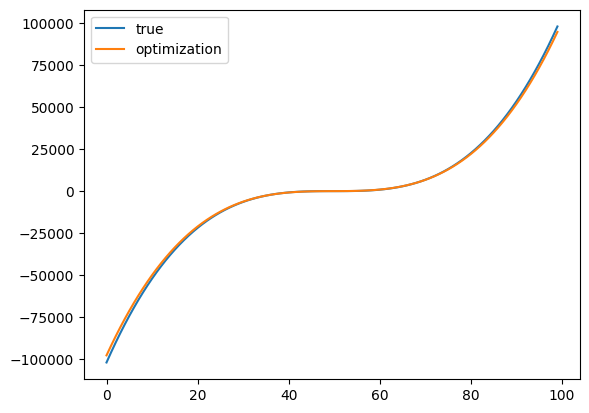

In [5]:
true_curve = TARGET_Y
optim_curve = [original_function(x, best_individual) for x in TARGET_X]
plt.plot(true_curve, label='true')
plt.plot(optim_curve, label='optimization')
plt.legend()
plt.show

# Аппроксимация игрушечной кривой

In [59]:
# Исходная функция (пусть это будет полином третьей степени)
#def original_function(x, coeffs):
#    return sum([coeffs[i] * x ** i for i in range(len(coeffs))])

def get_voigt_from_chromosome(chromosome, target_x, num_peaks):
    x0 = chromosome[0:num_peaks]
    ws = chromosome[num_peaks:num_peaks*2]
    amp = chromosome[num_peaks*2:num_peaks*3]
    gau = chromosome[num_peaks*3:num_peaks*4]
    
    return voigt_(target_x, amp, ws, x0, gau, True)

# Вычисление значения приспособленности хромосомы (MSE)
def fitness(chromosome, target_x, true_curve, num_peaks):    
    approx = get_voigt_from_chromosome(chromosome, target_x, num_peaks)
    mse = np.square(approx - true_curve).mean()
    
    return -float(mse)
    #return -np.mean((np.array([original_function(x, chromosome) for x in target_x]) - np.array(target_y)) ** 2)


# Генерация начальной популяции
def generate_population(pop_size, num_peaks=5):
    # chrom_len = 4*num_peaks
    population = []

    for _ in range(pop_size):
        chromosome = []
        chromosome.append(np.random.randint(1, 10, num_peaks))
        chromosome.append(np.random.uniform(0.1, 2, num_peaks))
        chromosome.append(np.random.uniform(0.1, 2, num_peaks))
        chromosome.append(np.random.uniform(0, 1, num_peaks))

        chromosome = np.array(chromosome).reshape((-1,1)).T[0]
        chromosome = chromosome.tolist()
        population.append(chromosome)

    return population

# Выбор родителей для скрещивания
#def select_parents(population):
#    # Выбор двух родителей случайным образом
#    return random.choices(population, k=2)

# Выбор родителей для скрещивания (метод турнира)
def select_parents(population, tournament_size, num_peaks):
    tournament = random.sample(population, tournament_size)
    return max(tournament, key=lambda x: fitness(x, TARGET_X, TARGET_Y, num_peaks))

# Скрещивание двух родителей
def crossover(parent1, parent2):
    # min_len = min(len(parent1), len(parent2))
    # crossover_point = random.randint(1, min_len - 1)
    crossover_point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2



# Мутация
def mutate(chromosome, mutation_rate):
    for i in range(len(chromosome)):
        if random.random() < mutation_rate:
            #chromosome[i] *= random.uniform(0, 2)  # диапазон мутации #####################
            chromosome[i] += random.uniform(-1, 1)/chromosome[i]
    return chromosome

# Генетический алгоритм
def genetic_algorithm(pop_size, generations, mutation_rate, target_x, target_y, tournament_size, num_peaks):
    population = generate_population(pop_size, num_peaks)
    #print("popul:", population)
    for generation in range(generations):
        print("Generation:", generation + 1)
        new_population = []
        for _ in range(pop_size // 2):  # Создаем новое поколение, заполняя популяцию вдвое меньшего размера
            parent1 = select_parents(population, tournament_size, num_peaks)
            parent2 = select_parents(population, tournament_size, num_peaks)
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            new_population.extend([child1, child2])
        population = new_population
        population.sort(key=lambda x: fitness(x, target_x, target_y, num_peaks), reverse=True)  # Сортировка по убыванию приспособленности
        best_individual = population[0]
        best_fitness = fitness(best_individual, target_x, target_y, num_peaks)
        print("Best Fitness:", best_fitness)
        print("Best Individual (Coefficients):", best_individual)
        print()
    return best_individual


In [7]:
# игрушечный спектр
x = np.linspace(-10, 10, 1000)
x0 = np.array([1, 5, -9, -1, 9])
ws = np.array([0.5, 1, 0.5, 2, 0.25])
amp = np.array([1, 4, 6, 9, 0.8])
gau = np.array([0.5, .5, 1, 0, 0.25])

true_chromosome = np.array([x0, ws, amp, gau]).reshape((-1,1))
true_chromosome = true_chromosome.tolist()

true_curve = voigt_(x, amp, ws, x0, gau, True)

In [78]:
POPULATION_SIZE = 50 # большой не имеет смысла
GENERATIONS = 150 # если уж упали в яму то это не спасет
MUTATION_RATE = 0.15 # это вообще ни на что как будто не влияет
TARGET_X = x  # Значения x
TARGET_Y = true_curve  # Значения  y
#TARGET_COEFFS = 
TOURNAMENT_SIZE = 30  # Размер турнира # чем выше тем лучше????
NUM_PEAKS = 5 # chrom_len = 4*num_peaks

best_individual = genetic_algorithm(POPULATION_SIZE, GENERATIONS, MUTATION_RATE, TARGET_X, TARGET_Y, TOURNAMENT_SIZE, NUM_PEAKS)
print("Final Best Fitness:", fitness(best_individual, TARGET_X, TARGET_Y, NUM_PEAKS))
print("Original Parameters:", true_chromosome)


Generation: 1
Best Fitness: -6.259743379772343
Best Individual (Coefficients): [7.0, 1.0, 8.0, 1.0, 4.126712286962386, 1.9866927289158098, 1.8252299507753191, 1.7475404160313288, 1.188092884070921, 1.4827362333142198, 1.8045957039726326, 1.666782691457982, 0.2609491622592234, 1.7278769824729838, 1.5406061583963793, 0.20942957420978936, -1.321513306362827, 0.33879769362094214, 0.8669568210982636, 0.90057960784228]

Generation: 2
Best Fitness: -5.23845663801902
Best Individual (Coefficients): [7.0, 1.0, 5.179133430044043, -1.1506363485847968, 5.0, 0.9644380918642979, 1.128744793225293, 0.9297163684522887, 1.5272500442794394, 1.0024292003554574, 0.7173014263427703, 0.3820393027913601, 1.254684438136957, 1.9819633425031433, 0.6139334822079503, 0.536672494547513, 0.9861962403525638, -0.08569467163806738, 0.22817482734315153, 0.90057960784228]

Generation: 3
Best Fitness: -4.74453311296611
Best Individual (Coefficients): [7.0, 1.0, 5.179133430044043, -1.1506363485847968, 5.0, 0.9644380918642

<function matplotlib.pyplot.show(close=None, block=None)>

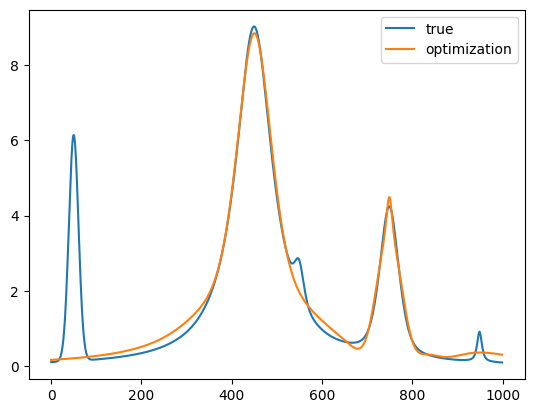

In [79]:
optim_curve = get_voigt_from_chromosome(best_individual, TARGET_X, NUM_PEAKS)
plt.plot(true_curve, label='true')
plt.plot(optim_curve, label='optimization')
plt.legend()
plt.show